In [2]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#标签编码
models = ['MA1', 'MA2', 'MB1', 'MB2', 'MC1', 'MC2']
label_encoder = LabelEncoder()
label_encoder.fit(models)

LabelEncoder()

In [3]:
# 加载包含标签的CSV文件
label_df = pd.read_csv('label.csv')  

label_df['model'] = label_encoder.transform(label_df['model'])

# 转换`failure_time`列特征格式，用于匹配
label_df['failure_time'] = pd.to_datetime(label_df['failure_time']).dt.strftime('%Y%m%d')
label_df['failure_time'] = label_df['failure_time'].astype("int64")

#转换model格式
label_df['model'] = label_df['model'].astype("int64")

# 在label_df中创建故障标记列
label_df['failure'] = 1

## 以Model_ID划分文件 & Add Failure babel & drop all NULL column

In [ ]:
def process_file(file_path):
    # 读取数据
    df = pd.read_csv(file_path)

    # 数据预处理
    df['model'] = label_encoder.transform(df['model'])
    
    # 合并数据，添加故障标签
    df = pd.merge(df, label_df[['model', 'disk_id', 'failure_time', 'failure']], 
                         left_on=['model', 'disk_id', 'ds'], 
                         right_on=['model', 'disk_id', 'failure_time'], 
                         how='left')
    
    # 将故障列的空值填充为0
    df['failure'].fillna(0, inplace=True)
    #print(sum(merged_df["failure"]))
    
    # 删除特定的列
    df.drop(['disk_id', 'failure_time',"ds"], axis=1, inplace=True)


    return df

def save_model_data(df, output_folder):
    model_ids = df['model'].unique()
    
    for model_id in model_ids:
        model_df = df[df['model'] == model_id]
        
        # 删除列中全为NULL的特征
        model_df = model_df.dropna(axis=1, how='all')
        model_df.drop(['model'], axis=1, inplace=True)
        # model_df = model_df.loc[:, model_df.var() != 0 | (model_df.columns == 'ds')]
        
        # 创建目标文件夹（如果不存在）
        model_folder = os.path.join(output_folder, f'model_{model_id}')
        os.makedirs(model_folder, exist_ok=True)

        # 保存到CSV文件
        output_file = os.path.join(model_folder, os.path.basename(file_path))
        model_df.to_csv(output_file, index=False)


# # 文件夹路径
# data_folder = r'D:\Anaconda3\envs\Resource\smartlog'
# output_folder = r'D:\Anaconda3\envs\Resource\filtered_data'

# 分割每个文件到各自model里的文件夹
for file_name in os.listdir(data_folder):
    file_path = os.path.join(data_folder, file_name)
    if os.path.isfile(file_path) and file_path.endswith('.csv'):
        df_processed = process_file(file_path)
        save_model_data(df_processed, output_folder)

## 欠采样多数类

In [5]:
from sklearn.utils import resample
def resample_data(df,  undersample_ratio,column='failure'):

    df_majority = df[df[column] == 0]
    df_minority = df[df[column] == 1]
    
    # 欠采样多数类 'failure == 0'
    majority_sample_size = int(len(df_majority) * undersample_ratio)
    
    df_majority_undersampled = resample(
                                        df_majority, 
                                        replace=False,    
                                        n_samples=majority_sample_size,     
                                        random_state=123
                                       )

    # 合并采样多数和少数类数据
    df_sampled = pd.concat([df_minority, df_majority_undersampled])

    return df_sampled

### 使用交叉验证和网格搜索来找到最佳的超参数组合。

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'base_estimator__max_depth': [5, 10],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
                           param_grid,
                           cv=5,
                           scoring='recall')  # 也可以尝试使用 'f1' 或其他指标

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


## SMOTE 过采样

In [6]:
#先对非故障样本欠采样
def smote_process_folder(folder_path, undersample_ratio):
    all_data = pd.DataFrame()
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path) and file.endswith('.csv'):
            df = pd.read_csv(file_path)
            # 对数据进行过欠采样
            df_sampled = resample_data(df, undersample_ratio)
            # 将处理后的数据添加到总数据集
            all_data = pd.concat([all_data, df_sampled], ignore_index=True)
    return all_data


In [7]:
folder_path = r'D:\Anaconda3\envs\Resource\filtered_data\model_4'   # 替换为您的文件夹路径
combined_data = smote_process_folder(folder_path,undersample_ratio=0.0001)

In [144]:
combined_data.describe()
sum(combined_data['failure'])

1556.0

In [128]:
folder_path = r'D:\Anaconda3\envs\Resource\filtered_data\model_5'   # 替换为您的文件夹路径
combined_data1 = smote_process_folder(folder_path,undersample_ratio=0.002)
df_cur = pd.concat([combined_data, combined_data1], ignore_index=True)

In [129]:
combined_data = df_cur

数据填充;drop var == 0

In [130]:
merged_df = combined_data
for col in merged_df.columns:
    # 检查该列是否完全为空
    if merged_df[merged_df['failure'] == 1][col].notna().any():
        mode_val = merged_df[merged_df['failure'] == 1][col].mode()[0]
        merged_df.loc[merged_df['failure'] == 1, col] = merged_df[merged_df['failure'] == 1][col].fillna(mode_val)

# 对于非故障数据（failure = 0），也使用众数填充
for col in merged_df.columns:
    if merged_df[merged_df['failure'] == 0][col].notna().any():
        mode_val = merged_df[merged_df['failure'] == 0][col].mode()[0]
        merged_df.loc[merged_df['failure'] == 0, col] = merged_df[merged_df['failure'] == 0][col].fillna(mode_val)

combined_data = merged_df


In [131]:
merged_df.describe()

,n_1,r_1,n_5,r_5,n_9,r_9,n_12,r_12,n_170,r_170,...,r_197,n_198,r_198,n_199,r_199,n_206,r_206,failure,n_211,r_211
count,21873.0,2.187300e+04,21873.000000,21873.000000,21873.0,21873.000000,21873.0,21873.000000,21873.000000,21873.000000,...,21873.000000,21873.0,21873.000000,21873.0,21873.000000,21873.0,21873.000000,21873.000000,21873.0,21873.000000
mean,100.0,4.673119e+02,99.849861,18.927993,100.0,10180.845517,100.0,24.956842,99.866136,18.928176,...,0.006263,100.0,0.077676,100.0,7.372651,100.0,0.116536,0.071138,100.0,2.277648
std,0.0,6.296289e+04,2.347770,252.831768,0.0,5082.553843,0.0,52.965192,2.096868,252.831775,...,0.613571,0.0,0.465676,0.0,588.549838,0.0,1.609198,0.257061,0.0,0.955120
min,100.0,0.000000e+00,0.000000,0.000000,100.0,11.000000,100.0,1.000000,0.000000,0.000000,...,0.000000,100.0,0.000000,100.0,0.000000,100.0,0.000000,0.000000,100.0,1.000000
25%,100.0,0.000000e+00,100.000000,0.000000,100.0,6422.000000,100.0,16.000000,100.000000,0.000000,...,0.000000,100.0,0.000000,100.0,0.000000,100.0,0.000000,0.000000,100.0,2.000000
50%,100.0,0.000000e+00,100.000000,0.000000,100.0,9659.000000,100.0,21.000000,100.000000,0.000000,...,0.000000,100.0,0.000000,100.0,0.000000,100.0,0.000000,0.000000,100.0,2.000000
75%,100.0,0.000000e+00,100.000000,0.000000,100.0,13489.000000,100.0,27.000000,100.000000,0.000000,...,0.000000,100.0,0.000000,100.0,0.000000,100.0,0.000000,0.000000,100.0,2.000000
max,100.0,9.309720e+06,100.000000,9071.000000,100.0,25747.000000,100.0,4185.000000,100.000000,9071.000000,...,85.000000,100.0,23.000000,100.0,82874.000000,100.0,97.000000,1.000000,100.0,13.000000


### 基于小样本数据进行特征相关性分析

In [134]:
# 提取 failure=1 的样本
failure_1_samples = combined_data[combined_data['failure'] == 1]

# 随机抽取相同数量的 failure=0 样本
failure_0_samples = combined_data[combined_data['failure'] == 0].sample(n=len(failure_1_samples), random_state=30)

# 合并样本
analyzed_samples = pd.concat([failure_1_samples, failure_0_samples])

correlation_matrix = analyzed_samples.corr()
correlation_with_target = correlation_matrix['failure'].sort_values(ascending=False)
#print(correlation_with_target)
selected_features = correlation_with_target[(correlation_with_target > 0.2) | (correlation_with_target < -0.1)].index.tolist()
#print(selected_features)

failure    1.000000
r_211      0.968425
r_180      0.621511
r_198      0.458173
r_9        0.392785
n_194      0.219825
r_170      0.173635
r_5        0.173633
r_196      0.173633
r_173      0.112607
r_195      0.077746
r_1        0.076488
r_206      0.051092
r_171      0.051092
r_187      0.032017
r_188      0.030709
r_197      0.027072
r_183      0.025023
r_199      0.020750
r_184      0.018011
r_172      0.017287
n_172     -0.017929
n_171     -0.017929
n_184     -0.018011
r_174     -0.066523
n_173     -0.073089
r_12      -0.076534
n_170     -0.150129
n_5       -0.150992
r_194     -0.219825
n_1             NaN
n_9             NaN
n_12            NaN
n_174           NaN
n_180           NaN
n_183           NaN
n_187           NaN
n_188           NaN
n_195           NaN
n_196           NaN
n_197           NaN
n_198           NaN
n_199           NaN
n_206           NaN
n_211           NaN
Name: failure, dtype: float64


去除共线性特征

In [135]:
import random
def select_random_features(features):
    selected_features = set()
    grouped_features = {}

    # 将特征按后缀分组
    for feature in features:
        suffix = ''.join(filter(str.isdigit, feature))
        grouped_features.setdefault(suffix, []).append(feature)

    # 对于每组后缀，随机选择一个特征
    for suffix, feat_group in grouped_features.items():
        selected_features.add(random.choice(feat_group))

    return list(selected_features)
    
adjusted_features = select_random_features(selected_features)
print(adjusted_features)
adjusted_data = combined_data[adjusted_features]

['r_198', 'n_170', 'r_9', 'r_180', 'n_5', 'r_194', 'r_211', 'failure']


#### 建立分类器

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

X = adjusted_data.drop('failure', axis=1)  # 特征数据
y = adjusted_data['failure']  # 目标变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [137]:
# num_majority = y_train.value_counts()[0]
# target_num_minority = num_majority // 50 
# smote = SMOTE(sampling_strategy={1: target_num_minority},random_state=42)

#对测试集重抽样
smote = SMOTE(sampling_strategy=1,random_state=30)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [141]:
#创建 AdaBoost 分类器实例，使用决策树作为基分类器
adaBoost_model = AdaBoostClassifier(
   base_estimator=DecisionTreeClassifier(max_depth=3),
   n_estimators=200,
   learning_rate=0.1, 
   random_state=30
)

#训练模型
adaBoost_model.fit(X_train_smote, y_train_smote)

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=30)

In [142]:
from sklearn.metrics import classification_report, accuracy_score
# 在测试集上进行预测
y_pred = adaBoost_model.predict(X_test)

# 计算并打印分类报告
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6083
         1.0       0.99      1.00      0.99       479

    accuracy                           1.00      6562
   macro avg       0.99      1.00      1.00      6562
weighted avg       1.00      1.00      1.00      6562



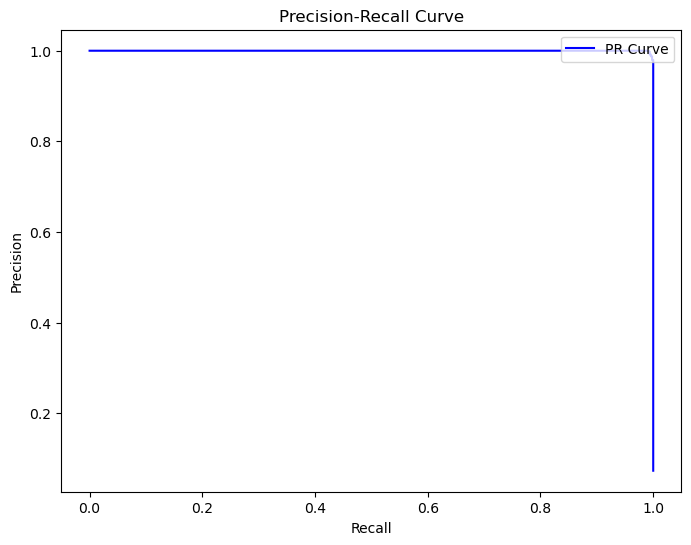

In [143]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
# 获取模型对测试集的预测概率
y_scores = adaBoost_model.predict_proba(X_test)[:, 1]  # 获取属于正类的概率

# 计算精确率和召回率
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 绘制 PR 曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [201]:
# 测试ing